In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.stats import norm
from scipy.stats import gaussian_kde

In [2]:
class Stock:
    def __init__(self , ticker , period , start , end):
        self.ticker = ticker
        self.period = period
        self.start = start
        self.end = end

    #  سود محاسبه میکنه
    def returns_period(self):
        data = yf.download(self.ticker , start = self.start , end = self.end)
        list_changes_peroid = []
        for i in range(0 , data.shape[0] , self.period):
            try:
                list_changes_peroid.append((data['Close'].iloc[i +5] - data['Close'].iloc[i]).values)
            except IndexError :
                pass
        list_changes_peroid = np.array(list_changes_peroid)
        return list_changes_peroid

    def show_details(self , list_changes , bounds):
        print(f'Mean : {np.mean(list_changes)} , Median : {np.median(list_changes)} , Std : {np.std(list_changes)}')
        x = np.linspace(np.min(list_changes) , np.max(list_changes) , 25)
        bin_width = (x[1] - x[0])
        y = norm.pdf(x, np.mean(list_changes), np.std(list_changes)) * list_changes.shape[0] * bin_width
        # با کم و زیاد کردن مقدار bounds  میتوانیم یک ترید آف بین اورفیت شدن و آندرفیت بودن تابع برقرار کنیم
        kde = gaussian_kde(list_changes.flatten() , bw_method = bounds )
        y2 = kde(x)
        y_scaled = y2 * list_changes.shape[0] * (x[1] - x[0]) 
        plt.plot(x , y , label = 'Normal Distrbution')
        plt.plot(x , y_scaled , label="KDE")
        plt.axvline(np.mean(list_changes) , color = 'red' , label = 'Mean' , linestyle = '--')
        plt.axvline(np.median(list_changes) , color = 'blue' , label = 'Median' , linestyle = '--')

        plt.legend()

    def show_Loss_dist(self , changes):
        mean_loss = -1 * np.mean(changes)
        std_dev = np.std(changes)
        range_loss = np.arange(0,1,0.01)
        list2 = []
        for i in range_loss:
            list2.append(np.percentile(changes , (1 - i) * 100))
            # list2.append(norm.ppf(i, loc=mean_loss, scale=std_dev))
        list2 = list2[::-1]
        values = list2
        probabilities = 1 - range_loss
        probabilities = np.array(probabilities[1:])
        values = np.array(values[1:])

        pdf = -np.diff(probabilities) / np.diff(values) 

        x = (values[:-1] + values[1:]) / 2 

        return x , pdf
        
        
class Portofolio(Stock):
    def __init__(self, ticker, weights, period, start, end):
        super().__init__(ticker=None, period=period, start=start, end=end)
        self.tickers = ticker  
        self.weights = weights

    def returns_period_all(self):
        ret_all = []
        for i in range(len(self.tickers)):
            self.ticker = self.tickers[i]  
            ret_all.append(self.returns_period())
        ret_all = np.array(ret_all)
        new_changes = np.ndarray.flatten(ret_all)
        new_changes = new_changes.reshape(len(self.tickers), int(len(new_changes) / len(self.tickers)))
        final_result = self.weights @ new_changes
        final_result = final_result.reshape(-1, 1)
        return final_result

for MSFT

In [10]:
# for one stock
msft = Stock('MSFT' , 5 , '2018-01-01' , '2024-01-01')
changes_msft = msft.returns_period()

[*********************100%***********************]  1 of 1 completed


Mean : 0.9591694575211535 , Median : 1.3400115966796875 , Std : 7.871291454440875


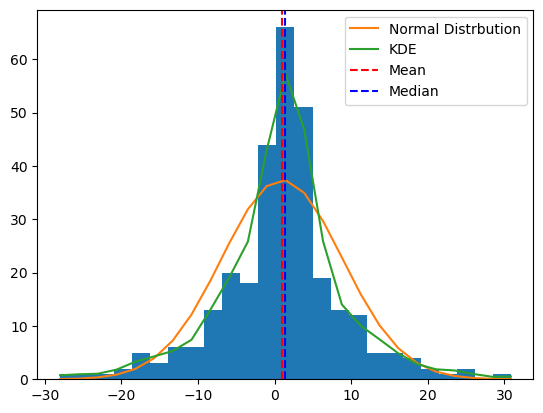

In [19]:
plt.hist(changes_msft , bins=25)
msft.show_details(changes_msft , 0.25)

Text(0, 0.5, 'Density')

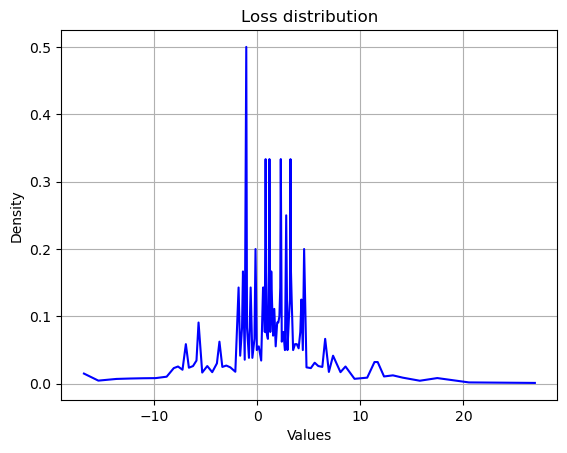

In [20]:
plt.plot(msft.show_Loss_dist(changes_msft)[0] , msft.show_Loss_dist(changes_msft)[1] , label='PDF', color='blue')
plt.grid(True)
plt.title('Loss distribution')
plt.xlabel('Values')
plt.ylabel('Density')

In [21]:
# Example for Var
mean_loss = -1 * np.mean(changes_msft)
std_dev = np.std(changes_msft)
confidence_level = 0.99

VaR = norm.ppf(confidence_level, loc=mean_loss, scale=std_dev)
print(f"VaR at {confidence_level*100}% confidence level: {VaR:.2f} with scipy.stats.norm.ppf ")

VaR_99 = np.percentile(changes_msft, (1 - 0.99) * 100)
print(f"VaR at {confidence_level*100}% confidence level: {-1 * VaR_99:.2f} with np.percentile")

VaR at 99.0% confidence level: 17.35 with scipy.stats.norm.ppf 
VaR at 99.0% confidence level: 19.89 with np.percentile


for portofolio

In [22]:
my_stocks = ["AAPL", "MSFT", "AMZN", "GOOGL", "TSLA"]
weights = np.array([0.1 , 0.1 , 0.2 , 0.3 , 0.1])

stocks = Portofolio(my_stocks , weights , 5 , '2018-01-01' , '2024-01-01')
changes_portofolio = stocks.returns_period_all()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Mean : 0.37389828881552056 , Median : 0.6174644470214843 , Std : 4.111927518764252


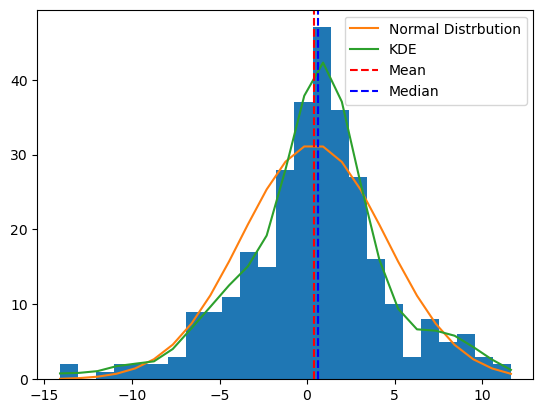

In [23]:
plt.hist(changes_portofolio , bins=25)
msft.show_details(changes_portofolio , 0.25)

Text(0, 0.5, 'Density')

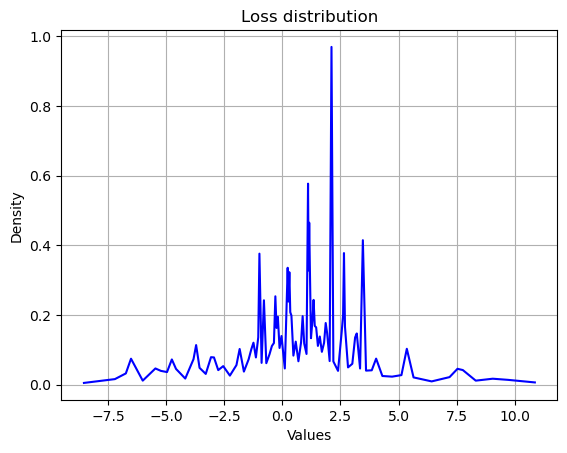

In [24]:
plt.plot(stocks.show_Loss_dist(changes_portofolio)[0] , stocks.show_Loss_dist(changes_portofolio)[1] , label='PDF', color='blue')
plt.grid(True)
plt.title('Loss distribution')
plt.xlabel('Values')
plt.ylabel('Density')